In [1]:
# Importing necessary modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import warnings
import seaborn as sns
from scipy import stats
from datetime import datetime

import statsmodels.api as sm
plt.style.use('ggplot')
%matplotlib inline

In [2]:
dataset = pd.read_csv('history2.csv')
dataset = dataset.dropna(how='any')
dataset['cost'] = dataset['cost'].str.replace(',', '')
dataset['cost'] = dataset['cost'].str.replace('$', '')
dataset['cost'] = dataset['cost'].str.replace(r"\(.*\)","")
dataset['cost'] = dataset['cost'].str.replace("--","")
dataset['cost'] = dataset['cost'].astype(float)
#dataset = dataset.astype(int)

dataset['date']=pd.to_datetime(dataset['date'], format='%m/%d/%Y', errors='coerce')
dataset.set_index(['date'], inplace=True)

dataset.head()

,cost
date,
2019-05-24,799900.0
2017-08-04,745000.0
2017-07-08,749900.0
2017-06-30,749900.0
2015-06-01,705827.0


In [3]:
dataset.dtypes

cost    float64
dtype: object

In [4]:
y = dataset['cost'].resample('MS').mean()
y.dropna(inplace=True)

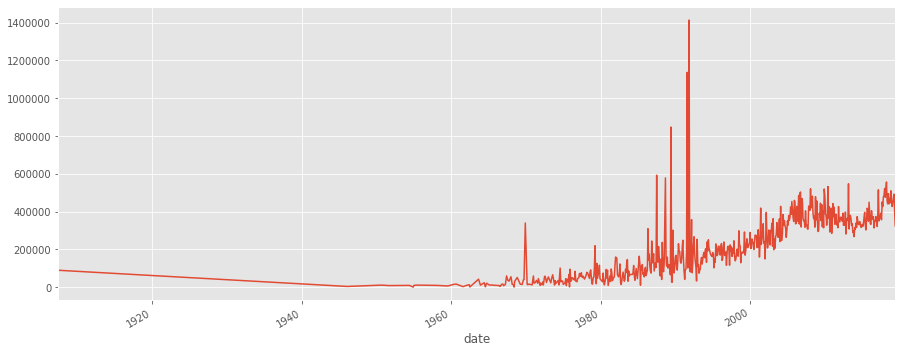

In [5]:
y.plot(figsize=(15, 6))
plt.show()

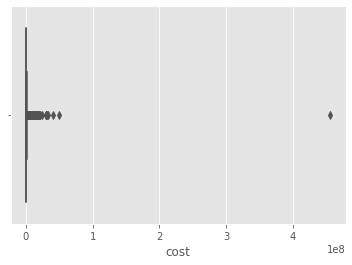

In [6]:
sns.boxplot(x=dataset['cost'])

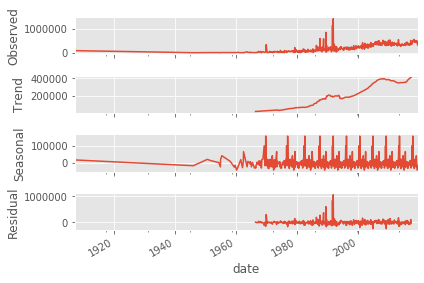

In [7]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive',freq=52)
decomposition.plot()
plt.show()

In [8]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Few parameter combinations are:')
print('{} x {}'.format(pdq[1], seasonal_pdq[1]))
print('{} x {}'.format(pdq[2], seasonal_pdq[2]))

Few parameter combinations are:
(0, 0, 1) x (0, 0, 1, 12)
(0, 1, 0) x (0, 1, 0, 12)


In [9]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:16250.422174297062
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:15668.422323101482
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:15120.493899740184
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:14595.278121796517
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:15126.362006423798
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:14861.57905539569
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:14718.644857047955
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:14595.50962426277
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:15920.999837498606
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:15525.037507986304
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:15096.864695220684
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:14596.663388175704
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:15507.318255002256
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:15407.973918731233
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:14731.525323539525
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:14598.594231264982
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:15383.626179632627
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:15081.0660311

In [10]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8809      0.030    -29.617      0.000      -0.939      -0.823
ma.S.L12      -0.9478      0.028    -33.795      0.000      -1.003      -0.893
sigma2      2.279e+10    1.2e-12   1.89e+22      0.000    2.28e+10    2.28e+10


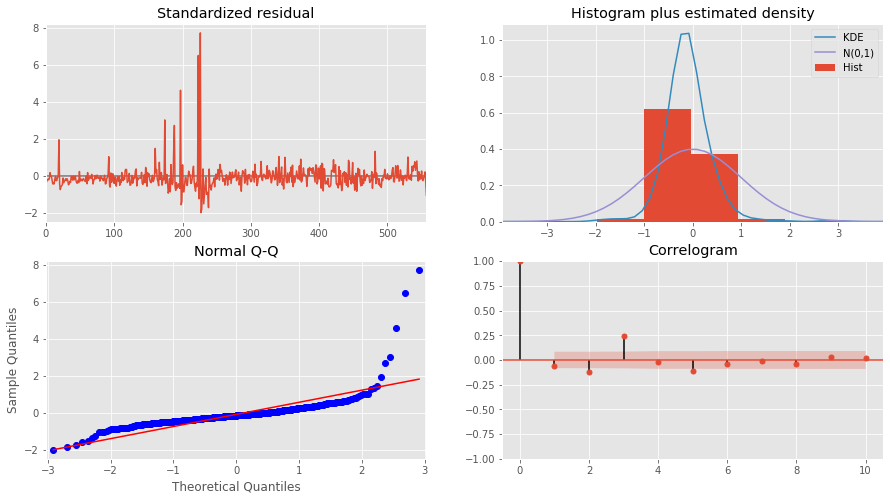

In [11]:
results.plot_diagnostics(figsize=(15, 8))
plt.show()

In [12]:
pred = results.get_prediction(start=(1), dynamic=False)
pred_ci = pred.conf_int()

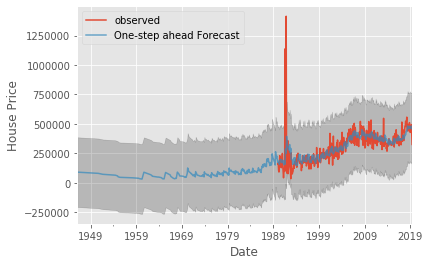

In [13]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('House Price')
plt.legend()

plt.show()

In [14]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-06-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 24632839641.67


In [15]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [16]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

ValueError: year 0 is out of range

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000022109391048> (for post_execute):


ValueError: year 0 is out of range

ValueError: year 0 is out of range